<h1> D7041E Lab6</h1>
Sune Larsson, sunlar-3@student.ltu.se

Elliot Eriksson, lelrek-1@student.ltu.se

In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from mackey_glass_gen import mackey_glass
from sklearn.metrics import accuracy_score

In [2]:
class ESN:
    def root_mean_square_error(self, y, y_hat):
        return np.sqrt(np.mean(np.square(y - y_hat)))
    

    def __init__(self, input_dim, reservoir_size_Nx, output_dim, spectral_radius=0.8, input_scaling=0.2, seed=42):
        self.input_dim = input_dim
        self.reservoir_size_Nx = reservoir_size_Nx
        self.output_dim = output_dim
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.last_training_state = None
        np.random.seed(seed)

        self.W_in = (np.random.uniform(-1, 1, [self.reservoir_size_Nx, self.input_dim + 1])) * self.input_scaling
        # Generate W
        self.W = np.random.uniform(-1, 1, [self.reservoir_size_Nx, self.reservoir_size_Nx])
        # Calculate the spectral radius of W (eigenvalues) and divide W by it
        eigenvalues = linalg.eigvals(self.W)
        max_abs_eigenvalue = max(abs(eigenvalues))
        self.W = self.W / max_abs_eigenvalue
        # Scale the W matrix with "ultimate" spectral radius
        self.W = self.W * self.spectral_radius
        self.W_out = None
        
    def reservoir_update(self, u, x):
        u_bias = np.append(u, 1)
        new_state = np.tanh(np.dot(self.W_in, u_bias) + np.dot(self.W, x))
        return new_state
    
    def train_ESN(self, input_data, Y_target, discard_steps, reg_param):
        time_steps = input_data.shape[0]
        X = np.zeros((1+ self.input_dim + self.reservoir_size_Nx, time_steps))

        reservoir_states = np.zeros((time_steps, self.reservoir_size_Nx))

        x = np.zeros((self.reservoir_size_Nx))

        for t in range(time_steps):
            if t == 0:
                # For the first time step, no previous output is available
                u = input_data[t]
            else:
                # Use teaching forcing signal
                u = Y_target[t - 1]  # y(n-1)
            #Equation 3 section 2
            #Evalutes the current state and previous reservoir state
            x = self.reservoir_update(u, x)
            reservoir_states[t] = x
            
        self.last_training_state = x
        augmented_reservoir_state = np.hstack([np.ones((time_steps, 1)), input_data.reshape(-1, 1), reservoir_states])

        X = augmented_reservoir_state[discard_steps:, :]    
        Y_target = Y_target[discard_steps:]
        
        beta = reg_param 
        I = np.eye(X.shape[1])
        self.W_out = np.linalg.solve(X.T @ X + beta * I, X.T @ Y_target)


    def predict(self, input_data, testing_steps):
        reservoir_state = self.last_training_state
        predictions = []

        current_input = input_data[0] # u
        
        for _ in range(testing_steps):
            reservoir_state = self.reservoir_update(current_input, reservoir_state)
            augmented_state = np.hstack([1, current_input, reservoir_state])
            prediction = augmented_state @ self.W_out
            predictions.append(prediction)
            current_input = prediction

        return np.array(predictions)

    def predictLeaf(self, X_test):
        predictions = []
        
        for i, signal in enumerate(X_test):
            # Initialize reservoir state to zero for each signal
            reservoir_state = np.zeros(self.reservoir_size_Nx)

            reservoir_state = self.reservoir_update(signal, reservoir_state)
            extended_state = np.hstack([reservoir_state, 1])
            output = extended_state @ self.W_out
            predictions.append(output)

        return np.array(predictions)


    def trainLeaf(self, X_train, y_train_onehot, reg_param):
        
        reservoir_states = []
        for signal in X_train:
            r_prev = np.zeros(self.reservoir_size_Nx)
            r_prev = self.reservoir_update(signal, r_prev)

            reservoir_states.append(r_prev)

        reservoir_states = np.array(reservoir_states)
        augmented_states = np.hstack([reservoir_states, np.ones((reservoir_states.shape[0], 1))])

        beta = reg_param
        I = np.eye(augmented_states.shape[1])
        self.W_out = np.linalg.solve(augmented_states.T @ augmented_states + beta * I, augmented_states.T @ y_train_onehot)


In [3]:

def sinusoidal_signal(n):
    n = np.arange(1, n + 1)
    return 0.5 * np.sin(n/4)


# 3. Modeling of dynamic systems with ESNs
def Sinusoid_ESN_testing():
    total_time_steps = 4000
    train_steps = 3000
    test_steps = total_time_steps - train_steps
    reservoir_size = 1000
    spectral_radius = 0.8
    input_scaling = 0.2
    reg_param = 1e-8
    nr_of_simulations = 10

    predictions = np.zeros((nr_of_simulations, test_steps))

    for run in range(nr_of_simulations):
        esn = ESN(input_dim=1, 
                reservoir_size_Nx=reservoir_size, 
                output_dim=1, 
                spectral_radius=spectral_radius, 
                input_scaling=input_scaling,
                seed=run)

        signal = sinusoidal_signal(total_time_steps)
        train_input = signal[:train_steps]
        test_input = signal[train_steps:]
        train_target = signal[1:train_steps+1]
        test_target = signal[train_steps+1:]

        esn.train_ESN(train_input, train_target , discard_steps=1000, reg_param=reg_param)

        prediction = esn.predict(test_input, test_steps)
        predictions[run] = prediction

        
    mean_predictions = np.mean(predictions, axis=0)
    # print(f'{predictions.shape=}')
    # print("Mean predictions: ", mean_predictions)
    
    plt.plot(test_target, label="True Signal")
    plt.plot(mean_predictions, label="ESN Predictions")
    plt.legend()
    plt.show()

In [4]:

# 3. Modeling of dynamic systems with ESNs
def Mackey_Glass_ESN_testing():
    total_time_steps = 4000
    train_steps = 3000
    test_steps = total_time_steps - train_steps
    reservoir_size = 1000
    spectral_radius = 0.8
    input_scaling = 0.2
    reg_param = 1e-8
    nr_of_simulations = 10

    signal = mackey_glass(17,total_time_steps)
    predictions = np.zeros((nr_of_simulations, test_steps))

    for run in range(nr_of_simulations):
        esn = ESN(input_dim=1, 
                reservoir_size_Nx=reservoir_size, 
                output_dim=1, 
                spectral_radius=spectral_radius, 
                input_scaling=input_scaling,
                seed=run)

        train_input = signal[:train_steps]
        test_input = signal[train_steps:]
        train_target = signal[1:train_steps+1]
        test_target = signal[train_steps+1:]

        esn.train_ESN(train_input, train_target , discard_steps=1000, reg_param=reg_param)

        prediction = esn.predict(test_input, test_steps)
        predictions[run] = prediction

        
    mean_predictions = np.mean(predictions, axis=0)

    # print(f'{predictions.shape=}')
    # print("Mean predictions: ", mean_predictions)
    
    plt.plot(test_target, label="True Signal")
    plt.plot(mean_predictions, label="ESN Predictions")
    plt.legend()
    plt.show()

    # print("Root mean square error: ", esn.root_mean_square_error(test_target, mean_predictions))


In [10]:

#Load the tsv files from the swedishLeaf dataset
def load_data():
    train_data = np.loadtxt("SwedishLeaf/SwedishLeaf_TRAIN.tsv", delimiter="\t")
    test_data = np.loadtxt("SwedishLeaf/SwedishLeaf_TEST.tsv", delimiter="\t")

    # Extract the features and labels
    X_train = train_data[:, 1:]
    y_train = train_data[:, 0]
    X_test = test_data[:, 1:]
    y_test = test_data[:, 0].astype(int)

    return X_train, y_train, X_test, y_test

# 4. Time-series classification with ESNs
def swedishLeaf_ESN_testing():
    X_train, y_train, X_test, y_test = load_data()

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    expected_categories = np.arange(1, 16)  # Classes 1 to 15

    encoder = OneHotEncoder(sparse_output=False, categories=[expected_categories])
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    
    # print(f'{X_train.shape=}')
    # print(f'{y_train.shape=}')

    # print(f'{X_test.shape=}')
    # print(f'{y_test.shape=}')

    reservoir_size = 800
    spectral_radius = 0.99
    input_scaling = 0.25
    reg_param = 1e-8
    nr_of_simulations = 10

    predictions = []

    for run in range(nr_of_simulations):
        esn = ESN(input_dim=X_train.shape[1], 
                reservoir_size_Nx=reservoir_size, 
                output_dim=y_train.shape[1], 
                spectral_radius=spectral_radius, 
                input_scaling=input_scaling,
                seed=run)

        esn.trainLeaf(X_train, y_train , reg_param=reg_param)

        prediction = esn.predictLeaf(X_test)
        predictions.append(prediction)

    # print(f'{predictions=}')
    mean_predictions = np.mean(predictions, axis=0)

    # The predicted labels are of by one so we need to add 1 to the predicted labels
    predicted_labels = np.argmax(mean_predictions, axis=1) +1
    # print(f'{predicted_labels=}')
    # print(f'{y_test=}')
    print(f'{accuracy_score(y_test, predicted_labels)=}')


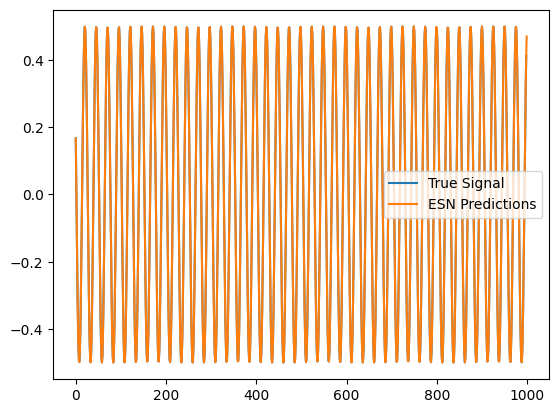

In [6]:
Sinusoid_ESN_testing()


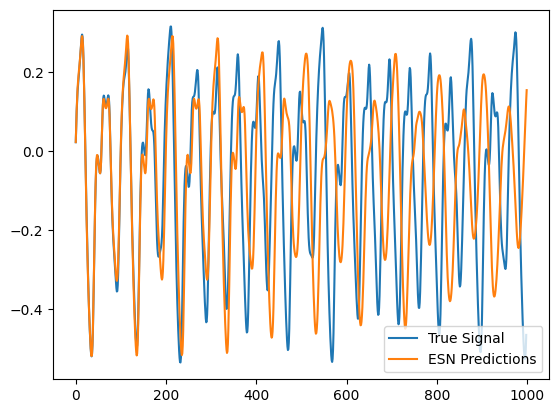

In [7]:
Mackey_Glass_ESN_testing()


In [11]:
swedishLeaf_ESN_testing()

accuracy_score(y_test, predicted_labels)=0.8192
